<a href="https://colab.research.google.com/github/blackgreenc/AI/blob/main/index_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#!pip install yfinance

In [27]:
import numpy as np
import pandas as df
import yfinance as yf #야후 파이낸스 데이터

There are0observations in the training data
There are254observations in the training data


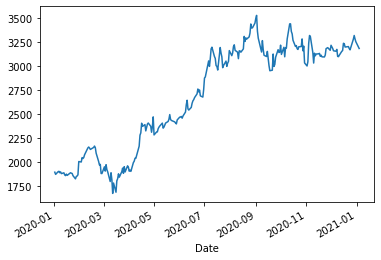

In [28]:
#아마존
AMZN = yf.download('AMZN',
                     start = '2020-01-01',
                     end = '2021-1-05',
                     progress = False)

AMZN_data = AMZN[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
AMZN_data.head(15)

print("There are" + str(AMZN_data[:"2000"].shape[0]) + "observations in the training data")
print("There are" + str(AMZN_data[:"2021"].shape[0]) + "observations in the training data")
AMZN_data['Adj Close'].plot()

There are0observations in the training data
There are2770observations in the training data


,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
Date,,,,,,
2021-01-04,12694.66,12950.22,12950.22,12537.42,12694.66,6546740000
2020-12-31,12888.28,12852.96,12904.09,12804.75,12888.28,4771390000
2020-12-30,12845.36,12900.03,12917.45,12828.79,12845.36,5292210000
2020-12-29,12843.49,12909.86,12925.53,12816.59,12843.49,4680780000
2020-12-28,12838.86,12813.97,12861.91,12747.05,12838.86,5076340000
2020-12-24,12711.01,12668.20,12732.55,12665.80,12711.01,3305950000
2020-12-23,12653.14,12733.75,12737.59,12649.60,12653.14,7028650000
2020-12-22,12717.56,12715.48,12761.23,12606.42,12717.56,5700760000
2020-12-21,12690.26,12575.60,12706.44,12474.03,12690.26,5156470000


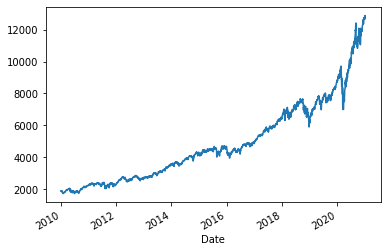

In [39]:
# 나스닥 100
NDX  = yf.download('NDX',
                     start = '2010-01-01',
                     end = '2021-1-05',
                     progress = False)

NDX_data = NDX[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
NDX_data.rename(columns={'Adj Close':'NDX_Adj Close', 'Open':'NDX_Open', 'High':'NDX_High', 'Low':'NDX_Low', 'Close':'NDX_Close', 'Volume':'NDX_Volume' }, inplace=True)


print("There are" + str(NDX_data[:"2000"].shape[0]) + "observations in the training data")

print("There are" + str(NDX_data[:"2021"].shape[0]) + "observations in the training data")
NDX_data['NDX_Adj Close'].plot()


NDX_data.loc[::-1].head(10)

There are0observations in the training data
There are2770observations in the training data


,GOLD_Adj Close,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume
Date,,,,,,
2021-01-04,24.00,23.85,24.80,23.62,24.62,41044700
2020-12-31,22.21,23.25,23.27,22.70,22.78,18088000
2020-12-30,22.66,22.97,23.28,22.85,23.24,16046500
2020-12-29,22.33,22.96,23.28,22.75,22.91,14663900
2020-12-28,22.27,23.52,23.54,22.80,22.84,15946700
2020-12-24,22.32,22.80,23.04,22.73,22.90,4920100
2020-12-23,22.26,22.62,23.03,22.56,22.83,11737800
2020-12-22,21.95,23.00,23.05,22.26,22.52,19820200
2020-12-21,22.44,23.25,23.41,22.95,23.02,20688200


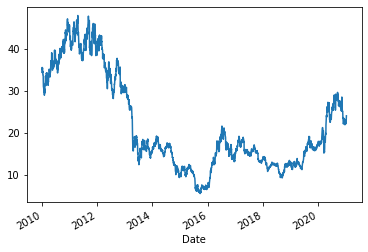

In [37]:
# 금값
GOLD  = yf.download('GOLD',
                     start = '2010-01-01',
                     end = '2021-1-05',
                     progress = False)

GOLD_data = GOLD[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
GOLD_data.rename(columns={'Adj Close':'GOLD_Adj Close', 'Open':'GOLD_Open', 'High':'GOLD_High', 'Low':'GOLD_Low', 'Close':'GOLD_Close', 'Volume':'GOLD_Volume' }, inplace=True)


print("There are" + str(GOLD_data[:"2000"].shape[0]) + "observations in the training data")
print("There are" + str(GOLD_data[:"2021"].shape[0]) + "observations in the training data")

GOLD_data['GOLD_Adj Close'].plot()
GOLD_data.loc[::-1].head(10)

There are0observations in the training data
There are2770observations in the training data


,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume
Date,,,,,,
2021-01-04,2.20,2.21,2.26,2.15,2.20,2512500
2020-12-31,2.17,2.22,2.26,2.15,2.17,2467800
2020-12-30,2.24,2.23,2.27,2.21,2.24,2441100
2020-12-29,2.21,2.27,2.30,2.20,2.21,2749500
2020-12-28,2.25,2.33,2.38,2.24,2.25,2657200
2020-12-24,2.30,2.39,2.40,2.29,2.30,1381500
2020-12-23,2.38,2.26,2.47,2.26,2.38,3636800
2020-12-22,2.24,2.35,2.36,2.23,2.24,3225900
2020-12-21,2.33,2.28,2.40,2.27,2.33,3104200


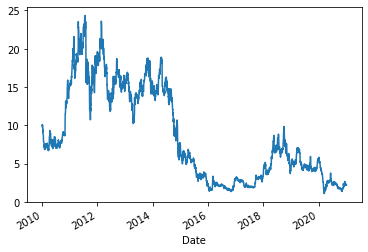

In [36]:
# 기름 
WTI  = yf.download('WTI',
                     start = '2010-01-01',
                     end = '2021-1-05',
                     progress = False)

WTI_data = WTI[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
WTI_data.rename(columns={'Adj Close':'WTI_Adj Close', 'Open':'WTI_Open', 'High':'WTI_High', 'Low':'WTI_Low', 'Close':'WTI_Close', 'Volume':'WTI_Volume' }, inplace=True)


print("There are" + str(WTI_data[:"2000"].shape[0]) + "observations in the training data")
print("There are" + str(WTI_data[:"2021"].shape[0]) + "observations in the training data")

WTI_data['WTI_Adj Close'].plot()
WTI_data.loc[::-1].head(10)

In [40]:
all_data = df.concat([WTI_data, NDX_data, GOLD_data], axis=1)

all_data.head(12)

,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,GOLD_Adj Close,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume
Date,,,,,,,,,,,,,,,,,,
2010-01-04,9.82,11.90,12.46,11.86,12.26,838800,1886.70,1882.69,1890.02,1881.63,1886.70,1931380000,34.34,40.70,41.18,40.25,40.39,14212200
2010-01-05,9.89,12.30,12.63,12.17,12.34,625400,1888.43,1887.28,1891.33,1877.52,1888.43,2367860000,34.77,40.66,41.10,40.04,40.89,13018600
2010-01-06,10.08,12.41,12.65,12.39,12.58,604700,1878.42,1887.91,1893.21,1873.90,1878.42,2253340000,35.51,41.32,42.34,41.14,41.76,12329200
2010-01-07,9.98,12.60,12.70,12.24,12.45,565300,1876.72,1878.16,1881.33,1867.62,1876.72,2270050000,35.00,41.67,41.67,40.89,41.17,9291000
2010-01-08,10.02,12.37,12.54,12.12,12.50,521100,1892.59,1870.90,1893.25,1868.55,1892.59,2145390000,35.22,41.60,41.67,40.70,41.43,9198600
2010-01-11,9.94,12.65,13.27,12.14,12.40,1177400,1886.24,1896.05,1897.49,1876.25,1886.24,2077890000,35.40,42.57,42.64,41.32,41.64,13778000
2010-01-12,9.54,12.33,12.43,11.80,11.90,921200,1861.79,1874.75,1876.37,1852.31,1861.79,2368320000,34.26,41.16,41.52,39.95,40.30,12126500
2010-01-13,9.15,11.97,12.00,11.36,11.42,1778300,1886.13,1868.20,1890.81,1855.27,1886.13,2318350000,34.60,40.53,40.80,39.43,40.70,9581100
2010-01-14,9.46,11.42,11.90,11.42,11.80,890300,1886.52,1880.46,1891.73,1880.35,1886.52,2254170000,34.41,40.65,40.85,39.95,40.47,8470600


In [32]:
def ts_train_test(all_data, time_steps, for_periods):
    #traing & test set 만들기